# Clustering (prototype)
This notebook implements a prototype using the prototype data from ... in order to identify a valid and reasonable approach for clustering the insurance data, while maintaining low resource-costs.

## Setup

### Imports

In [29]:
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path.home()/ "Desktop" / "Insurance_Project"
os.chdir(PROJECT_ROOT)

print(os.getcwd())

C:\Users\phili\Desktop\Insurance_Project


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from src.models import clustering as c
import importlib


In [31]:
import joblib

### Data collection and cleaning

In [32]:
from src.data import preprocessing as pr
data = c.load_data(PROJECT_ROOT/"dashboard"/"assets"/"dashboard_data.csv")

In [33]:
data.head(5)

,Unnamed: 0,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,incident_city,incident_location,witnesses,total_claim_amount,auto_make,auto_model,auto_year,month_sin,month_cos,severe
0,0,328.0,48.0,OH,250/500,1000.0,1406.91,0.0,466132,MALE,...,Columbus,9935 4th Drive,2.0,71610.0,Saab,92x,2004.0,-8.660254e-01,5.000000e-01,0
1,1,228.0,42.0,IN,250/500,2000.0,1197.22,5000000.0,468176,MALE,...,Riverwood,6608 MLK Hwy,0.0,5070.0,Mercedes,E400,2007.0,1.224647e-16,-1.000000e+00,0
2,2,134.0,29.0,OH,100/300,2000.0,1413.14,5000000.0,430632,FEMALE,...,Columbus,7121 Francis Lane,3.0,34650.0,Dodge,RAM,2007.0,-1.000000e+00,-1.836970e-16,0
3,3,256.0,41.0,IL,250/500,2000.0,1415.74,6000000.0,608117,FEMALE,...,Arlington,6956 Maple Drive,2.0,63400.0,Chevrolet,Tahoe,2014.0,5.000000e-01,-8.660254e-01,0
4,4,228.0,44.0,IL,500/1000,1000.0,1583.91,6000000.0,610706,MALE,...,Arlington,3041 3rd Ave,1.0,6500.0,Accura,RSX,2009.0,1.224647e-16,-1.000000e+00,0


In [34]:
numerical_columns = data.select_dtypes(include='number').columns# type: ignore
ordinal_columns = ['policy_state','policy_csl','insured_sex', 'insured_education_level']
ordinal_categories = [['OH', 'IN', 'IL'],
                      ['100/300', '250/500', '500/1000'],
                      ['MALE', 'FEMALE'],
                      ['High School', 'Masters','JD', 'MD'],]
cat_cols = data.select_dtypes(include="object").columns# type: ignore
bool_cols = []
for col in data.columns:
    unique_vals = set(data[col].dropna().unique())
    if unique_vals.issubset({True, False}):
        data[col] = data[col].astype('boolean')  # nullable bool
        bool_cols.append(col)
cat_cols = [x for x in cat_cols if x not in bool_cols]
nominal_columns = [x for x in cat_cols if x not in ordinal_columns]

In [35]:
# preprocessor, data_processed = pr.prepreprocessing_pipeline(
#     X = data,
#     numerical_cols=numerical_columns,
#     ordinal_cols=ordinal_columns,
#     ordinal_categories=ordinal_categories,
#     nominal_cols=nominal_columns,
#     bool_cols=bool_cols
# )

In [36]:
data_processed = c.load_data(PROJECT_ROOT/"data"/"clustering"/"input_clustering.csv")

In [37]:
print(data_processed)

     Unnamed: 0  num__months_as_customer  num__age  num__policy_deductable  \
0             0                 1.078140  0.990836               -0.222383   
1             1                 0.208995  0.334073                1.412784   
2             2                -0.608002 -1.088913                1.412784   
3             3                 0.452355  0.224613                1.412784   
4             4                 0.208995  0.552994               -0.222383   
..          ...                      ...       ...                     ...   
995         995                -1.746582 -0.103769               -0.222383   
996         996                 0.704407  0.224613               -0.222383   
997         997                -0.642767 -0.541611               -1.039966   
998         998                 2.208028  2.523284                1.412784   
999         999                 2.190645  2.304363               -0.222383   

     num__policy_annual_premium  num__umbrella_limit  num__insu

In [38]:
print(data_processed.shape)
print(data.shape)

for col in data.columns:
    print(col)

(1000, 2095)
(1000, 24)
Unnamed: 0
months_as_customer
age
policy_state
policy_csl
policy_deductable
policy_annual_premium
umbrella_limit
insured_zip
insured_sex
insured_education_level
insured_occupation
insured_relationship
incident_state
incident_city
incident_location
witnesses
total_claim_amount
auto_make
auto_model
auto_year
month_sin
month_cos
severe


## K-means clustering

### Identifying optimal amount of clusters via Elbow method

We identify the optimal value for `n` in `sklearn.cluster.KMeans` using the elbow method. We plot the inertias against the number of clusters and find that the there are only marginal benefits in increasing the amount of clusters beyond `2` 

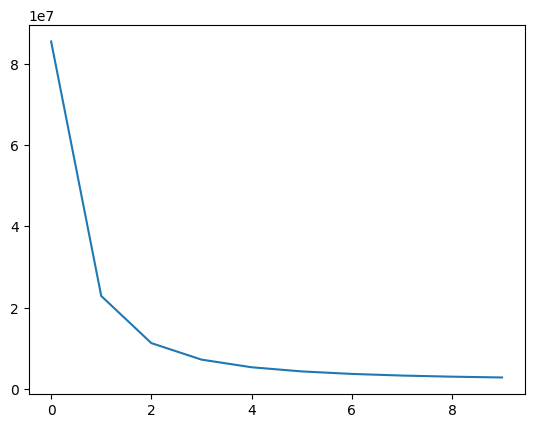

In [39]:
inertias = c.elbow_inertia(data_processed)
plt.plot(range(10),inertias)

In [40]:
elbow = 4

In [41]:
importlib.reload(c)


<module 'src.models.clustering' from 'C:\\Users\\phili\\Desktop\\Insurance_Project\\src\\models\\clustering.py'>

### Implementing K-Means algorithm

We use the value identified via the elbow method, and implement the K-Means clustering algorithm, using the varian `k-means++` and a `euclidean` metric as the basis of the model. We achieve a moderate silhoutte score of 0.59 using this method. Implying a some moderately strong clusters within the data, but it is still under uncertainty whetever these clusters will be helpful for predicting the insurance premium of individual policy-takers but it might yield interesting insigths.

In [42]:
labels, model, sil = c.kmeans_cluster(data_processed, n_cluster = 2)

In [43]:
labeled_data, centroids = c.kmeans_add_labels_and_cluster_centers(data, labels, numerical_columns)

In [44]:
labeled_data.head(5)

,Unnamed: 0,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,incident_location,witnesses,total_claim_amount,auto_make,auto_model,auto_year,month_sin,month_cos,severe,Cluster kmeans
0,0,328.0,48.0,OH,250/500,1000.0,1406.91,0.0,466132,MALE,...,9935 4th Drive,2.0,71610.0,Saab,92x,2004.0,-8.660254e-01,5.000000e-01,False,1
1,1,228.0,42.0,IN,250/500,2000.0,1197.22,5000000.0,468176,MALE,...,6608 MLK Hwy,0.0,5070.0,Mercedes,E400,2007.0,1.224647e-16,-1.000000e+00,False,1
2,2,134.0,29.0,OH,100/300,2000.0,1413.14,5000000.0,430632,FEMALE,...,7121 Francis Lane,3.0,34650.0,Dodge,RAM,2007.0,-1.000000e+00,-1.836970e-16,False,1
3,3,256.0,41.0,IL,250/500,2000.0,1415.74,6000000.0,608117,FEMALE,...,6956 Maple Drive,2.0,63400.0,Chevrolet,Tahoe,2014.0,5.000000e-01,-8.660254e-01,False,1
4,4,228.0,44.0,IL,500/1000,1000.0,1583.91,6000000.0,610706,MALE,...,3041 3rd Ave,1.0,6500.0,Accura,RSX,2009.0,1.224647e-16,-1.000000e+00,False,1


In [45]:
centroids

,Unnamed: 0,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,witnesses,total_claim_amount,auto_year,month_sin,month_cos,severe
Cluster kmeans,,,,,,,,,,,,,
0,749.0,204.343313,39.087824,1080.838323,1261.214491,1.001996e+06,503035.568862,1.546906,51936.267465,2004.670659,0.015557,0.015896,0.191617
1,249.0,203.563126,38.807615,1191.382766,1251.578537,1.200401e+06,499386.108216,1.426854,53590.921844,2005.537074,-0.026177,0.019968,0.210421


In [46]:
print("sil", sil)

sil 0.5914749083011496


In [47]:
X_pca, variance_ratios, components = c.apply_pca(data_processed, n_composition=2)
print(variance_ratios)


[9.75512433e-01 4.99743655e-05]


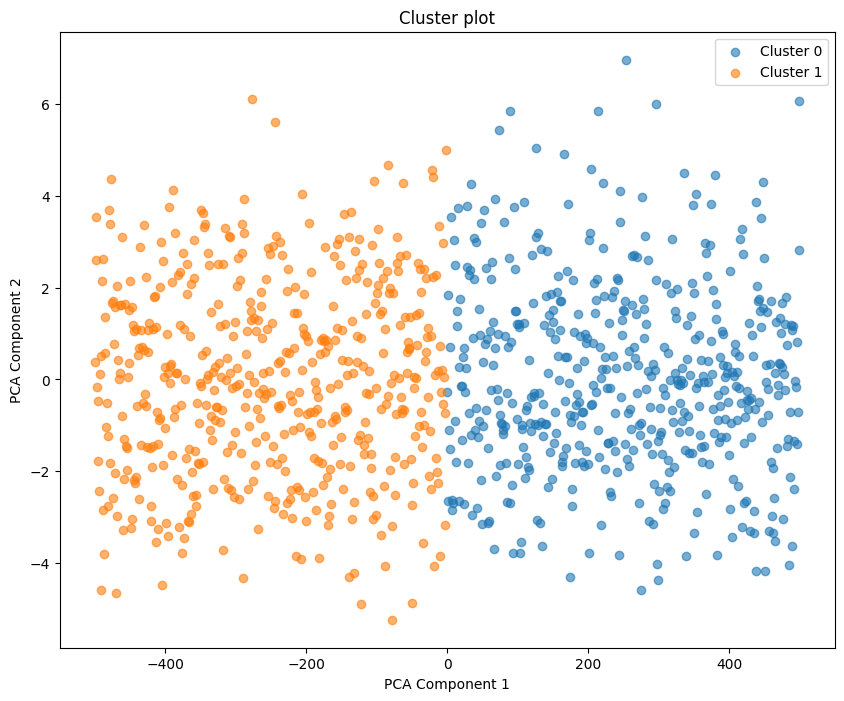

In [48]:
c.plot_clusters_2d(X_pca, labels)

### Implementing the DBSCAN algorithm

In this prototype the DBSCAN model is unable to generalise towards any meaningful clustering solution, and we have to acknowledge that issues with dimensionality might mean that `DBSCAN` is simply not a good fit for this problem. 

We discard the model as a proposed solution due to the marginal benefits in finding a viable way to test, and propose instead that we stick with `KMeans` in order to investigate if the clustering algorithm can yield any future benefit

In [49]:
try:
    labels, model, ep, min  = c.dbscan_clusters(data_processed)
    db_scaned_data, db_centroids = c.kmeans_add_labels_and_cluster_centers(data, labels, numerical_columns)
    db_scaned_data.head(5)
    print(set(labels))
    print(len(set(labels)))
    outliers = [i for i in labels if i == -1]
    print(len(outliers))
except ValueError as e:
    print(e)

DBSCAN could not find any valid clustering solution


### Conclusion

KMeans outperforms DBSCAN when clustering the data. DBscan will fail to generalize and will either result in a clustering that is much to granular too analyse, or result in an inordinate amount of labeled outliers. My hypothesis is that this is due to the high dimensionality of the data. 

One solution could be to reduce dimensionality with feature selection and methods like PCA or t-SNE, while another could be to stick with KMEANS since it seems to produce more robust results when faced with high dimensional data. 

KMEANS will be regardes as our main approach for this project due to time constraints, and the relatively small marginal benefit from changing to DBSCAN.